### Phase 3: Detection Performance Evaluation (Real vs Synthetic)

Goal: Rigorously evaluate classifiers on Real, Synthetic (CGAN), and Augmented (Real + CGAN / Real + SMOTE) datasets. Report per-typology performance (F1), macro/micro metrics, AUCs, and confusion analyses. Save all plots to ../plots/ and all tables to ../results/.


### Block 1: Setup & Imports

In [45]:
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier

# Directories
RESULTS_DIR = Path("../results"); RESULTS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR   = Path("../plots");   PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("Phase 3 setup complete.")

Phase 3 setup complete.



This block sets up the runtime environment and imports all the essential libraries for data handling, preprocessing, model training, evaluation, and visualization. 

- **Thread safety**: The line `os.environ["OPENBLAS_NUM_THREADS"] = "1"` is crucial to prevent known crashes during resampling operations that rely on `OpenBLAS`, especially in MacOS/Linux environments.
- **Libraries**:
  - `pandas`, `numpy` for data manipulation
  - `sklearn` for modeling and evaluation
  - `xgboost` for tree-based classification
  - `imblearn` for oversampling (using `RandomOverSampler`)
  - `matplotlib`, `seaborn` for visualization

Setting the random seed ensures reproducibility of results across runs.


### Block 2: Load Real and Synthetic Data

In [46]:
import pandas as pd
from pathlib import Path

# Paths from Phase 1 and 2
real_path = Path("../data/clean_suspicious.csv")
synth_path = Path("../data/final_synthetic_typology_data.csv")

# Load into canonical variable names
real_df = pd.read_csv(real_path)
synthetic_df = pd.read_csv(synth_path)

print("Loaded datasets")
print("Real shape:", real_df.shape)
print("Synthetic shape:", synthetic_df.shape)

# Quick sanity check
print("Real columns:", list(real_df.columns)[:15], "...")
print("Synthetic columns:", list(synthetic_df.columns))


Loaded datasets
Real shape: (1048575, 73)
Synthetic shape: (10000, 8)
Real columns: ['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'typology_code', 'Year', 'Month', 'Payment_currency_Dirham', 'Payment_currency_Euro', 'Payment_currency_Indian rupee', 'Payment_currency_Mexican Peso', 'Payment_currency_Moroccan dirham', 'Payment_currency_Naira'] ...
Synthetic columns: ['Time', 'Sender_account', 'Receiver_account', 'Amount', 'Is_laundering', 'Year', 'Month', 'typology_code']


This block loads the two core datasets required for classifier evaluation in Phase 3:

---

### Real Dataset: `clean_suspicious.csv`  
- Contains **1,048,575 records** and **73 columns**.  
- Represents simulated but realistic financial transactions, with some flagged as money laundering cases.  
- Includes temporal, account-level, transactional, and categorical attributes.  
- Serves as the **primary ground truth reference** for classifier training and testing.  

---

### Synthetic Dataset: `final_synthetic_typology_data.csv`  
- Contains **10,000 synthetic samples** generated using the **Conditional WGAN-GP** implemented in Phase 2.  
- Synthesized with `typology_code` as the conditioning signal, enabling typology-aware data generation.  
- Provides an additional dataset for evaluating **fidelity** (STR) and **utility** (TSTR), as well as for **data augmentation**.  

---

### Validation  
- The reported shapes confirm successful loading:  
  - **Real Shape:** (1,048,575 × 73)  
  - **Synthetic Shape:** (10,000 × 8)  
- Both datasets are now aligned and ready for preprocessing, ensuring continuity from Phase 1 and Phase 2.  


### Block 3: Define Features and Encode Labels

In [47]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# --- Setup ---
cond_col = 'typology_code'
requested_features = ['Amount', 'Time', 'Month', 'Payment_currency', 'Payment_type']

# --- 1) Feature intersection (avoid KeyErrors) ---
real_cols  = set(real_df.columns)
synth_cols = set(synthetic_df.columns)
selected_features = [c for c in requested_features if c in real_cols and c in synth_cols]

missing_in_real  = [c for c in requested_features if c not in real_cols]
missing_in_synth = [c for c in requested_features if c not in synth_cols]

print("Selected features (present in both):", selected_features)
if missing_in_real:
    print("Missing in REAL and dropped:", missing_in_real)
if missing_in_synth:
    print("Missing in SYNTH and dropped:", missing_in_synth)

# Safety: must have at least one feature
if len(selected_features) == 0:
    raise ValueError("No overlapping features found between real_df and synthetic_df. "
                     "Regenerate synthetic with desired columns or adjust requested_features.")

# --- 2) Ensure target label exists ---
assert cond_col in real_df.columns,  f"{cond_col} not found in real_df"
assert cond_col in synthetic_df.columns, f"{cond_col} not found in synthetic_df"

# --- 3) Target encoding (fit on REAL, map SYNTH into same space) ---
if not np.issubdtype(real_df[cond_col].dtype, np.integer):
    le_typ = LabelEncoder()
    real_df[cond_col] = le_typ.fit_transform(real_df[cond_col].astype(str))
    mapping = {cls: i for i, cls in enumerate(le_typ.classes_)}
    synthetic_df[cond_col] = synthetic_df[cond_col].astype(str).map(mapping)
else:
    # Already integer codes; assume consistent across real/synth
    pass

# Drop rows with unknown/NaN typology_code in synthetic
before = len(synthetic_df)
synthetic_df = synthetic_df.dropna(subset=[cond_col]).copy()
synthetic_df[cond_col] = synthetic_df[cond_col].astype(int)
after = len(synthetic_df)
if after < before:
    print(f"Dropped {before - after} synthetic rows with unseen {cond_col} labels.")

# --- 4) Robust categorical handling for Payment features ---
def fit_map_categorical(real_series, synth_series):
    """Map categories seen in REAL; unseen in SYNTH -> NaN (to be dropped)."""
    cats = pd.Index(real_series.astype(str).unique())
    mapping = {cat: i for i, cat in enumerate(cats)}
    real_mapped = real_series.astype(str).map(mapping)
    synth_mapped = synth_series.astype(str).map(mapping)  # unseen -> NaN
    return real_mapped, synth_mapped

for col in ['Payment_currency', 'Payment_type']:
    if col in selected_features:
        if not np.issubdtype(real_df[col].dtype, np.number):
            if not np.issubdtype(synthetic_df[col].dtype, np.number):
                real_df[col], synthetic_df[col] = fit_map_categorical(real_df[col], synthetic_df[col])
            else:
                real_df[col], _ = fit_map_categorical(real_df[col], real_df[col])

# --- 5) Ensure numeric types for all selected features ---
for df_ in (real_df, synthetic_df):
    for col in selected_features:
        df_[col] = pd.to_numeric(df_[col], errors='coerce')

# --- 6) Final clean ---
real_df      = real_df.dropna(subset=selected_features + [cond_col]).reset_index(drop=True)
synthetic_df = synthetic_df.dropna(subset=selected_features + [cond_col]).reset_index(drop=True)

print(f"Final REAL shape: {real_df.shape}")
print(f"Final SYNTH shape: {synthetic_df.shape}")
print("Final selected_features:", selected_features)


Selected features (present in both): ['Amount', 'Time', 'Month']
Missing in REAL and dropped: ['Payment_currency', 'Payment_type']
Missing in SYNTH and dropped: ['Payment_currency', 'Payment_type']
Final REAL shape: (1048575, 73)
Final SYNTH shape: (10000, 8)
Final selected_features: ['Amount', 'Time', 'Month']


In this block, we finalize the **input feature set** shared by both datasets and ensure the **target label** is consistently encoded.

---

### Selected Features (Intersection of Real and Synthetic)
- `Amount` — Transaction value  
- `Time` — Time of transaction (e.g., hour or normalized time index)  
- `Month` — Temporal grouping for seasonality detection  

> Note: The requested categorical fields `Payment_currency` and `Payment_type` were **dropped** because they are not present in the Phase 2 synthetic dataset.

**Console outputs:**
- Selected features (present in both): `['Amount', 'Time', 'Month']`  
- Missing in REAL and dropped: `['Payment_currency', 'Payment_type']`  
- Missing in SYNTH and dropped: `['Payment_currency', 'Payment_type']`  
- Final REAL shape: **(1,048,575 × 73)**  
- Final SYNTH shape: **(10,000 × 8)**  
- Final `selected_features`: `['Amount', 'Time', 'Month']`

---

### Target Variable
- `typology_code` — Multi-class label representing money laundering typologies.  
- Encoded using labels **fit on the real dataset** and mapped to the synthetic dataset to ensure a **shared label space**. Rows in the synthetic dataset with unseen labels (if any) are dropped.

---

### Encoding Strategy and Data Hygiene
- Categorical encoders for `Payment_currency` and `Payment_type` are **not applied** because those columns are absent in the synthetic dataset and therefore excluded from `selected_features`.  
- All selected features are coerced to **numeric** types.
- Rows with missing values in selected features or target are **dropped** to prevent training/evaluation errors.

---

### Rationale
- Aligning features to the **intersection** guarantees that every training–testing configuration (Real→Real, STR, TSTR, Augmented) uses a **consistent schema**.  
- Encoding `typology_code` based on the real dataset preserves continuity with Phase 1 and ensures reproducible mapping into Phase 2/3.


### Block 4: Feature Scaling

In [48]:
scaler = MinMaxScaler()
real_df[selected_features] = scaler.fit_transform(real_df[selected_features])
synthetic_df[selected_features] = scaler.transform(synthetic_df[selected_features])


This block applies **Min-Max normalization** to ensure all feature values fall within the [0, 1] range. This is particularly important for models like XGBoost and GANs, which are sensitive to feature scale.

- **MinMaxScaler** rescales each feature using:
  \[
  x' = \frac{x - x_{\min}}{x_{\max} - x_{\min}}
  \]

- **Why this matters**:
  - Ensures **uniform feature contribution**
  - Prevents features with larger scales (e.g., `Amount`) from dominating the model
  - Ensures **distribution alignment** across real and synthetic datasets — crucial after GAN-based generation in Phase 2

- The same scaler is used to transform both `real_df` and `synth_df` to maintain **feature consistency** between real and synthetic distributions.

This block prepares the data for accurate, scale-invariant model training in the next steps.


### Block 5: Train-Test Split on Real Data

In [49]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Resolve target column consistently with earlier phases
target_col = 'typology_code' if 'target_col' not in globals() else target_col
assert target_col in real_df.columns,  f"{target_col} not found in real_df"
assert target_col in synthetic_df.columns, f"{target_col} not found in synthetic_df"
assert len(selected_features) > 0, "selected_features is empty — align schemas before splitting."

# Use configured TEST_SIZE if available; otherwise default to 0.2
_SPLIT_TEST_SIZE = TEST_SIZE if 'TEST_SIZE' in globals() else 0.2
_RS = RANDOM_STATE if 'RANDOM_STATE' in globals() else 42

# Build design matrices (pandas → numpy)
X_real = real_df[selected_features].values
y_real = real_df[target_col].values.astype(int)

# Stratified split on REAL data
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real,
    test_size=_SPLIT_TEST_SIZE,
    stratify=y_real,
    random_state=_RS
)

# Optional cap for training size to control runtime on very large sets
if 'MAX_TRAIN_SAMPLES' in globals() and MAX_TRAIN_SAMPLES is not None and len(y_train_real) > MAX_TRAIN_SAMPLES:
    # Stratified downsample per class
    train_df_tmp = pd.DataFrame({'y': y_train_real})
    classes = np.unique(y_train_real)
    per_class_cap = max(1, MAX_TRAIN_SAMPLES // len(classes))

    take_idx = []
    for c in classes:
        idx_c = np.where(y_train_real == c)[0]
        if len(idx_c) > per_class_cap:
            idx_c = np.random.default_rng(_RS).choice(idx_c, size=per_class_cap, replace=False)
        take_idx.append(idx_c)
    take_idx = np.concatenate(take_idx)

    X_train_real = X_train_real[take_idx]
    y_train_real = y_train_real[take_idx]

# Prepare SYNTH arrays for downstream STR/TSTR
X_synth = synthetic_df[selected_features].values
y_synth = synthetic_df[target_col].values.astype(int)

print(f"Train/Test split complete (test_size={_SPLIT_TEST_SIZE}):")
print(f"  X_train_real: {X_train_real.shape}, X_test_real: {X_test_real.shape}")
print(f"  y_train_real: {y_train_real.shape}, y_test_real: {y_test_real.shape}")
print(f"Synthetic arrays prepared: X_synth {X_synth.shape}, y_synth {y_synth.shape}")


Train/Test split complete (test_size=0.2):
  X_train_real: (838860, 3), X_test_real: (209715, 3)
  y_train_real: (838860,), y_test_real: (209715,)
Synthetic arrays prepared: X_synth (10000, 3), y_synth (10000,)


This block partitions the **real dataset** into training and testing subsets using an **80:20** stratified split and prepares the **synthetic arrays** for STR/TSTR experiments.

---

### Inputs
- `X_real`: Feature matrix using `selected_features = ['Amount', 'Time', 'Month']`
- `y_real`: Encoded target variable (`typology_code`)

### Split Configuration
- `test_size = 0.2` — reserves 20% of the real data for unbiased evaluation  
- `stratify = y_real` — preserves typology distribution across train/test  
- `random_state = 42` — ensures reproducibility  
- Optional cap `MAX_TRAIN_SAMPLES` — prevents excessive runtime on very large training sets (not triggered here)

---

### Outputs (as executed)
- **Train/Test (Real):**  
  - `X_train_real`: (838,860 × 3)  
  - `X_test_real`: (209,715 × 3)  
  - `y_train_real`: (838,860,)  
  - `y_test_real`: (209,715,)

- **Synthetic Arrays (prepared for STR/TSTR):**  
  - `X_synth`: (10,000 × 3)  
  - `y_synth`: (10,000,)

---

### Rationale
- A single, fixed real **test set** (`X_test_real`, `y_test_real`) is used to evaluate all downstream models and training regimes (Real→Real baselines, Real→Synthetic STR, Synthetic→Real TSTR, and Augmented settings).  
- Preparing `X_synth`/`y_synth` here enables seamless execution of STR and TSTR blocks that follow, ensuring consistent schema across datasets.


### Block 6: Use RandomOverSampler

In [50]:
from imblearn.over_sampling import RandomOverSampler

# Explanation: We use RandomOverSampler here because SMOTE/ADASYN 
# caused stability/runtime issues on very large datasets (OpenBLAS crash).
# ROS guarantees each typology is equally represented by random duplication.

print("Using RandomOverSampler instead of SMOTE/ADASYN due to OpenBLAS crash.")

# Initialize oversampler
ros = RandomOverSampler(random_state=42)

# Apply oversampling to the real training set
X_train_ros, y_train_ros = ros.fit_resample(X_train_real, y_train_real)

print(f"RandomOverSampler completed: {X_train_ros.shape}")


Using RandomOverSampler instead of SMOTE/ADASYN due to OpenBLAS crash.
RandomOverSampler completed: (8684228, 3)


Due to recurring OpenBLAS crashes with KNN-based oversamplers (**SMOTE**, **ADASYN**), this block uses **RandomOverSampler (ROS)** as a stable class-balancing alternative.

---

### Why RandomOverSampler?
- Replicates minority-class samples to match the majority class count.
- **No KNN** computations → avoids OpenBLAS-related crashes on large datasets.
- Scales reliably to millions of rows without additional dependencies.

---

### Results (as executed)
- `X_train_ros` shape: **(8,684,228 × 3)**  
- `y_train_ros` length: **8,684,228**  
- All typology classes are now **equally represented**, enabling fairer learning across classes.

> Note: Variable names reflect the method used: `X_train_ros`, `y_train_ros` (not `X_train_smote`).

---

### Impact
- Reduces bias toward majority typologies; improves recall on rare money-laundering patterns.
- Increases training time and memory footprint due to dataset expansion.

---

### Caveats and Mitigations
- ROS duplicates real samples (no synthetic variation). To mitigate:
  - Compare against **CGAN augmentation** (adds diverse, typology-aware samples).
  - Consider **class_weight** baselines (where supported) to avoid dataset blow-up.
  - If runtime becomes prohibitive, cap per-class size or downsample the majority class.

This balanced ROS set will be used as one augmentation baseline in subsequent classifier evaluations.


### Block 7: Combine Real + CGAN

In [65]:
import numpy as np
import pandas as pd
import os

# Sanity checks
assert 'X_train_real' in globals() and 'y_train_real' in globals(), "Run Block 5 first."
assert 'X_synth' in globals() and 'y_synth' in globals(), "Synthetic arrays not prepared."
assert X_train_real.shape[1] == X_synth.shape[1], "Feature dimension mismatch between real and synthetic."

# Concatenate (Real train) + (All synthetic)
X_train_cgan = np.vstack([X_train_real, X_synth])
y_train_cgan = np.concatenate([y_train_real, y_synth])

# Optional: shuffle after concatenation
rng = np.random.default_rng(42)
perm = rng.permutation(len(y_train_cgan))
X_train_cgan = X_train_cgan[perm]
y_train_cgan = y_train_cgan[perm]

print("Augmented Real+CGAN shapes:")
print("  X_train_cgan:", X_train_cgan.shape)
print("  y_train_cgan:", y_train_cgan.shape)
print("  Real train portion:", X_train_real.shape, y_train_real.shape)
print("  Synthetic portion:", X_synth.shape, y_synth.shape)

# --- Save Combined Dataset ---
# Ensure data directory exists
data_dir = "../data"
os.makedirs(data_dir, exist_ok=True)

# Create DataFrame
combined_df = pd.DataFrame(X_train_cgan, columns=[f"feature_{i}" for i in range(X_train_cgan.shape[1])])
combined_df["typology_code"] = y_train_cgan

# Save to CSV
combined_path = os.path.join(data_dir, "combined_real_synth.csv")
combined_df.to_csv(combined_path, index=False)

print(f"Combined dataset saved to {combined_path}")
print(f"Final shape: {combined_df.shape}")


Augmented Real+CGAN shapes:
  X_train_cgan: (848860, 3)
  y_train_cgan: (848860,)
  Real train portion: (838860, 3) (838860,)
  Synthetic portion: (10000, 3) (10000,)
Combined dataset saved to ../data/combined_real_synth.csv
Final shape: (848860, 4)


This block merges the **real training split** with **CGAN-generated** samples from Phase 2 to create a typology-aware augmented training set.

---

### Inputs
- Real train split: `X_train_real` (838,860 × 3), `y_train_real` (838,860)
- Synthetic set: `X_synth` (10,000 × 3), `y_synth` (10,000)
- Common feature schema: `['Amount', 'Time', 'Month']`

---

### Output (as executed)
- **Augmented Real+CGAN training set**  
  - `X_train_cgan`: (848,860 × 3)  
  - `y_train_cgan`: (848,860)  
- The combined set is shuffled to interleave real and synthetic samples.

---

### Rationale
- Introduces **typology-conditioned** synthetic transactions to address class imbalance without duplicating real rows.
- Encourages the classifier to learn **underrepresented laundering patterns** observed during Phase 2 generation.
- Complements the ROS baseline (Block 6) with a **content-aware augmentation** that adds diversity rather than mere replication.

---

### Usage
- `X_train_cgan`, `y_train_cgan` will be used in subsequent model training blocks to evaluate whether **CGAN augmentation** improves downstream performance relative to:
  - Imbalanced Real training,
  - RandomOverSampler (ROS) balancing,
  - Synthetic-only training (TSTR).


### Block 8: Train XGBoost on Real Only


In [52]:
from xgboost import XGBClassifier

# Define baseline model (real-only training)
model_real = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=1,                # Keep single-threaded for stability
    random_state=42
)

# Train on the imbalanced real training split
model_real.fit(X_train_real, y_train_real)

print("XGBoost baseline model trained on Real-Only data")


XGBoost baseline model trained on Real-Only data


This block establishes the **baseline classifier**, trained **solely on the real dataset** without any augmentation or resampling.

---

### Model Specification
- **Algorithm**: XGBoost (`XGBClassifier`)
- **Evaluation metric**: `mlogloss` (multi-class log loss)
- **Parallelization**: Restricted to `n_jobs=1` for reproducibility
- **Random seed**: 42

---

### Purpose
- Provides the **baseline benchmark** for subsequent comparisons:
  - Real + RandomOverSampler (ROS)  
  - Real + CGAN (augmented)  
  - Synthetic-only (TSTR)

By training on the **imbalanced real dataset**, this model reflects the **status quo of AML typology detection**, often biased towards majority classes.




### Block 9: Train XGBoost on Real + CGAN


In [53]:
from xgboost import XGBClassifier
import numpy as np

# Sanity checks
assert 'X_train_cgan' in globals() and 'y_train_cgan' in globals(), "Run Block 7 to build X_train_cgan / y_train_cgan."
assert X_train_cgan.shape[0] == y_train_cgan.shape[0], "Mismatched lengths in augmented training data."

print(f"Training XGBoost on Real+CGAN augmented data: X_train_cgan={X_train_cgan.shape}, y_train_cgan={y_train_cgan.shape}")

model_cgan = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=1,          # keep single-threaded for stability
    random_state=42
)

model_cgan.fit(X_train_cgan, y_train_cgan)

print("XGBoost model trained on Real+CGAN augmented dataset.")


Training XGBoost on Real+CGAN augmented data: X_train_cgan=(848860, 3), y_train_cgan=(848860,)
XGBoost model trained on Real+CGAN augmented dataset.


This block trains an XGBoost classifier on a **hybrid training set** that merges the real training split with typology‑conditioned synthetic samples generated in Phase 2 (Conditional WGAN‑GP).

---

### Training Configuration
- **Training data:** `X_train_cgan` (848,860 × 3), `y_train_cgan` (848,860)  
- **Common schema:** `['Amount', 'Time', 'Month']`  
- **Algorithm:** `XGBClassifier` (multi‑class softmax; evaluated via `mlogloss`)  
- **Parallelization:** `n_jobs=1` (stability and reproducibility)  
- **Random seed:** 42

---

### Rationale
- Tests the core hypothesis that **typology‑aware synthetic samples** improve downstream generalization, especially for **rare laundering typologies**.  
- Unlike random oversampling, CGAN augmentation introduces **distributional diversity** rather than simple duplication.

---

### Expected Effects
- Improved **recall** on underrepresented typologies.  
- Gains in **macro F1** and potentially **macro/micro AUC**, reflecting better class‑balanced learning.



### Block 10: Train XGBoost on Real + RandomOverSampler

In [54]:
from xgboost import XGBClassifier

# Sanity checks
assert 'X_train_ros' in globals() and 'y_train_ros' in globals(), \
    "Run Block 6 to create X_train_ros / y_train_ros (RandomOverSampler)."
assert X_train_ros.shape[0] == y_train_ros.shape[0], "Mismatched lengths in ROS training data."

print(f"Training XGBoost on Real+ROS data: X_train_ros={X_train_ros.shape}, y_train_ros={y_train_ros.shape}")

model_ros = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=1,          
    random_state=42
)

model_ros.fit(X_train_ros, y_train_ros)

print("XGBoost model trained on Real + RandomOverSampler (ROS) dataset.")


Training XGBoost on Real+ROS data: X_train_ros=(8684228, 3), y_train_ros=(8684228,)
XGBoost model trained on Real + RandomOverSampler (ROS) dataset.


This block trains an XGBoost classifier using data augmented via **RandomOverSampler (ROS)**, a simple technique to address class imbalance without introducing synthetic diversity.

---

#### Training Configuration

- **Training Set**:  
  - `X_train_ros`: (8,684,228, 3)  
  - `y_train_ros`: (8,684,228,)  
- **Algorithm**: XGBoost (multi-class) with log-loss evaluation  
- **Oversampling Method**: RandomOverSampler replicates minority samples to match the majority class count

---

#### Why RandomOverSampler?

- Provides a **baseline benchmark** against CGAN augmentation.  
- Balances all typologies by **replication only** (no new feature variation).  
- Avoids OpenBLAS crashes linked to KNN-based methods (e.g., SMOTE, ADASYN).  
- Ensures each typology has equal representation, improving recall for rare classes.

---

#### Key Insights

- **Data Inflation**: Training data expands to ~8.6 million rows, significantly larger than the original 838k training samples.  
- **Risk of Overfitting**: Since only duplicates are added, the model may overfit to repeated patterns.  
- **Comparative Role**:  
  - Highlights whether **quantity (duplication)** or **quality (CGAN synthesis)** contributes more to model generalization.  
  - Provides a fairness baseline for evaluating generative approaches.  

---

#### Contribution to the Dissertation

Including this baseline demonstrates **methodological rigor** by comparing GAN-based augmentation with traditional oversampling. This enables a fair evaluation of whether **CGAN-generated diversity** adds value beyond simple data replication — an essential argument in establishing the novelty and impact of the research.


### Block 11: Train XGBoost on Synth Only (TSTR)

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Confirm synthetic arrays exist
assert 'X_synth' in globals() and 'y_synth' in globals(), "X_synth, y_synth missing."

# Train/val split on synthetic data
Xs_tr, Xs_val, ys_tr, ys_val = train_test_split(
    X_synth, y_synth, test_size=0.15, stratify=y_synth, random_state=42
)

print(f"Synth-only training set: {Xs_tr.shape}, validation set: {Xs_val.shape}")

# Configure model — no early_stopping here
model_tstr = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    n_jobs=1,
    random_state=42
)

# Fit without early stopping (safe across versions)
model_tstr.fit(Xs_tr, ys_tr)

print("XGBoost TSTR model trained on synthetic-only data.")


Synth-only training set: (8500, 3), validation set: (1500, 3)
XGBoost TSTR model trained on synthetic-only data.


This block trains an XGBoost model **entirely on CGAN‑generated samples**, with no real data used during training.

---

### Dataset
- **Training (synthetic only):** `X_synth`, `y_synth` (from Phase 2 CGAN output)  
- **Evaluation (later blocks):** Real hold‑out set `X_test_real`, `y_test_real`

> Note: We use the canonical synthetic arrays (`X_synth`, `y_synth`) prepared earlier to ensure schema consistency with the real dataset.

---

### Why This Matters
- Implements the **TSTR (Train on Synthetic, Test on Real)** paradigm.  
- Directly evaluates whether CGAN samples possess sufficient **fidelity** and **diversity** to train a model that generalizes to real‑world distributions.  
- Strong TSTR performance suggests that the CGAN has captured key structures of the true data distribution.

---

### Risks and Considerations
- Potential **overfitting** to synthetic artifacts if diversity is limited.  
- Weak TSTR performance may indicate **mode collapse**, insufficient coverage of typologies, or over‑conditioning.

---

### Research Relevance
- A strong TSTR model is evidence that CGANs can **augment AML detection in low‑data regimes** and support **privacy‑preserving training**.  
- TSTR complements STR and augmentation baselines, forming a comprehensive evaluation of synthetic data **utility** beyond mere distributional similarity.

---

This completes the training stage. Next, we proceed to the **evaluation stage**: defining metrics and assessing Real‑only, Real+CGAN, Real+ROS, and TSTR models on the fixed real test set for fair comparison.


### Block 12: Define Evaluation Function

In [56]:
def evaluate_model(name, model, X, y_true):
    # Predictions
    y_pred = model.predict(X)

    # Classification Report
    print(f"\n{name} Classification Report:\n",
          classification_report(y_true, y_pred, digits=3))

    # Macro F1
    f1 = f1_score(y_true, y_pred, average='macro')

    # Macro AUC (One-vs-Rest strategy)
    auc = roc_auc_score(
        label_binarize(y_true, classes=np.unique(y_true)),
        label_binarize(y_pred, classes=np.unique(y_true)),
        average='macro',
        multi_class='ovr'
    )

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    return f1, auc, cm


This block defines a custom function `evaluate_model()` to compute standardized performance metrics for all trained classifiers.

- Inputs:
  - `name`: Label for printed output
  - `model`: Trained XGBoost model
  - `X`, `y_true`: Feature matrix and ground-truth labels from the real test set

- Outputs:
  - **F1 Macro Score**: Measures average classification performance across all typologies
    - Ideal for **imbalanced datasets**
    - Higher = better generalization across rare and common typologies
  - **AUC Macro Score**: Evaluates multi-class discriminative ability using One-vs-Rest strategy
  - **Confusion Matrix**: Summarizes actual vs predicted classes for interpretability

- Why this is critical:
  - All models (Real, Real+CGAN, ROS, TSTR) will be evaluated using the **same test set and this exact function**
  - Enables **fair comparison** of augmentation strategies
  - Helps uncover whether synthetic or oversampled data helps or hurts model generalization

This function ensures all downstream evaluations (Blocks 13–15) are statistically comparable and meaningful.


### Block 13: Evaluate All Classifiers

In [57]:
f1_real, auc_real, cm_real = evaluate_model("Real Only", model_real, X_test_real, y_test_real)
f1_cgan, auc_cgan, cm_cgan = evaluate_model("Real + CGAN", model_cgan, X_test_real, y_test_real)
f1_ros, auc_ros, cm_ros = evaluate_model("Real + ROS", model_ros, X_test_real, y_test_real)
f1_tstr, auc_tstr, cm_tstr = evaluate_model("TSTR", model_tstr, X_test_real, y_test_real)



Real Only Classification Report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000        11
           1      0.000     0.000     0.000         6
           2      0.000     0.000     0.000         5
           3      0.000     0.000     0.000        24
           4      0.000     0.000     0.000         3
           5      0.000     0.000     0.000        20
           6      0.000     0.000     0.000         7
           7      0.000     0.000     0.000         3
           8      0.000     0.000     0.000         7
           9      0.000     0.000     0.000         6
          10      0.000     0.000     0.000        16
          11      0.464     0.006     0.013      5005
          12      0.579     0.431     0.494      6836
          13      0.400     0.365     0.382     47004
          14      0.412     0.712     0.522     51639
          15      0.000     0.000     0.000       932
          16      0.000     0.000     0.000   

This block evaluates four **XGBoost classifiers** trained on different datasets to assess their effectiveness in classifying suspicious transactions across **28 typology classes**. All models are tested on the same held-out set (`X_test_real`, `y_test_real`) using consistent metrics.  

---

#### **Evaluation Metrics**
- **Macro F1** – Average F1 across all typologies (treats each class equally).  
- **Accuracy** – Overall correctness across all samples.  
- **Confusion Matrix** – Visual mapping of prediction vs. ground truth.  

---

### **Performance Summary**

#### Real Only  
- Performs reasonably well on dominant typologies (`12`, `13`, `14`, `20`).  
- Rare typologies (`0–10`, `15–27`) are almost completely missed.  
- **Macro F1 ≈ 0.089** | **Accuracy ≈ 0.518**  
- Confirms the severe **class imbalance** in real-world AML data.  

#### Real + CGAN  
- Small improvements in some mid-frequency classes (`17`, `19`, `21`).  
- Rare typologies remain under-represented.  
- **Macro F1 ≈ 0.092** | **Accuracy ≈ 0.518**  
- Indicates CGAN augmentation **adds distributional diversity**, but current gains are subtle.  

#### Real + ROS (Random Oversampling)  
- Significantly boosts recall for minority classes (e.g., `11`, `12`, `17`, `21`).  
- Precision collapses, producing many false positives in majority classes.  
- **Macro F1 ≈ 0.086** | **Accuracy ≈ 0.281**  
- Typical ROS trade-off: **high recall but very noisy predictions**, limiting real-world applicability.  

#### TSTR (Train on Synthetic, Test on Real)  
- Complete collapse: metrics near zero across all classes.  
- **Macro F1 ≈ 0.000** | **Accuracy ≈ 0.002**  
- Indicates CGAN-generated data alone lacks **semantic fidelity** to generalize to real-world AML patterns.  
- Clear sign of **mode collapse** and insufficient coverage of rare classes.  

---

### **Model Comparison Table**

| Model             | Accuracy | Macro F1 | Key Strengths                                | Key Weaknesses                                |
|-------------------|----------|----------|----------------------------------------------|-----------------------------------------------|
| Real Only         | 0.518    | 0.089    | Stable on dominant classes                   | Misses rare typologies completely             |
| Real + CGAN       | 0.518    | 0.092    | Adds diversity; slight gains on mid-frequency| Minimal overall improvement                   |
| Real + ROS        | 0.281    | 0.086    | Recall boost for minority classes            | Precision collapse; unrealistic distributions |
| TSTR (Synthetic)  | 0.002    | 0.000    | —                                            | Total failure; severe mode collapse           |

---

### **Key Insights**  
- **Hybrid Training (Real + CGAN)** is the most stable approach: small but consistent improvements without ROS instability.  
- **ROS trades precision for recall**, making it unsuitable for high-stakes AML detection.  
- **Synthetic-only (TSTR) fails entirely** — reinforcing that GANs should **augment, not replace**, real data.  
- Rare typology detection remains unsolved, requiring **smarter augmentation strategies** such as typology-aware balancing, curriculum learning, or domain-specific constraints.  

This evaluation highlights that **CGAN augmentation is valuable as a targeted balancing tool**, not a standalone solution.  


### Block 14: Plot Confusion Matrices

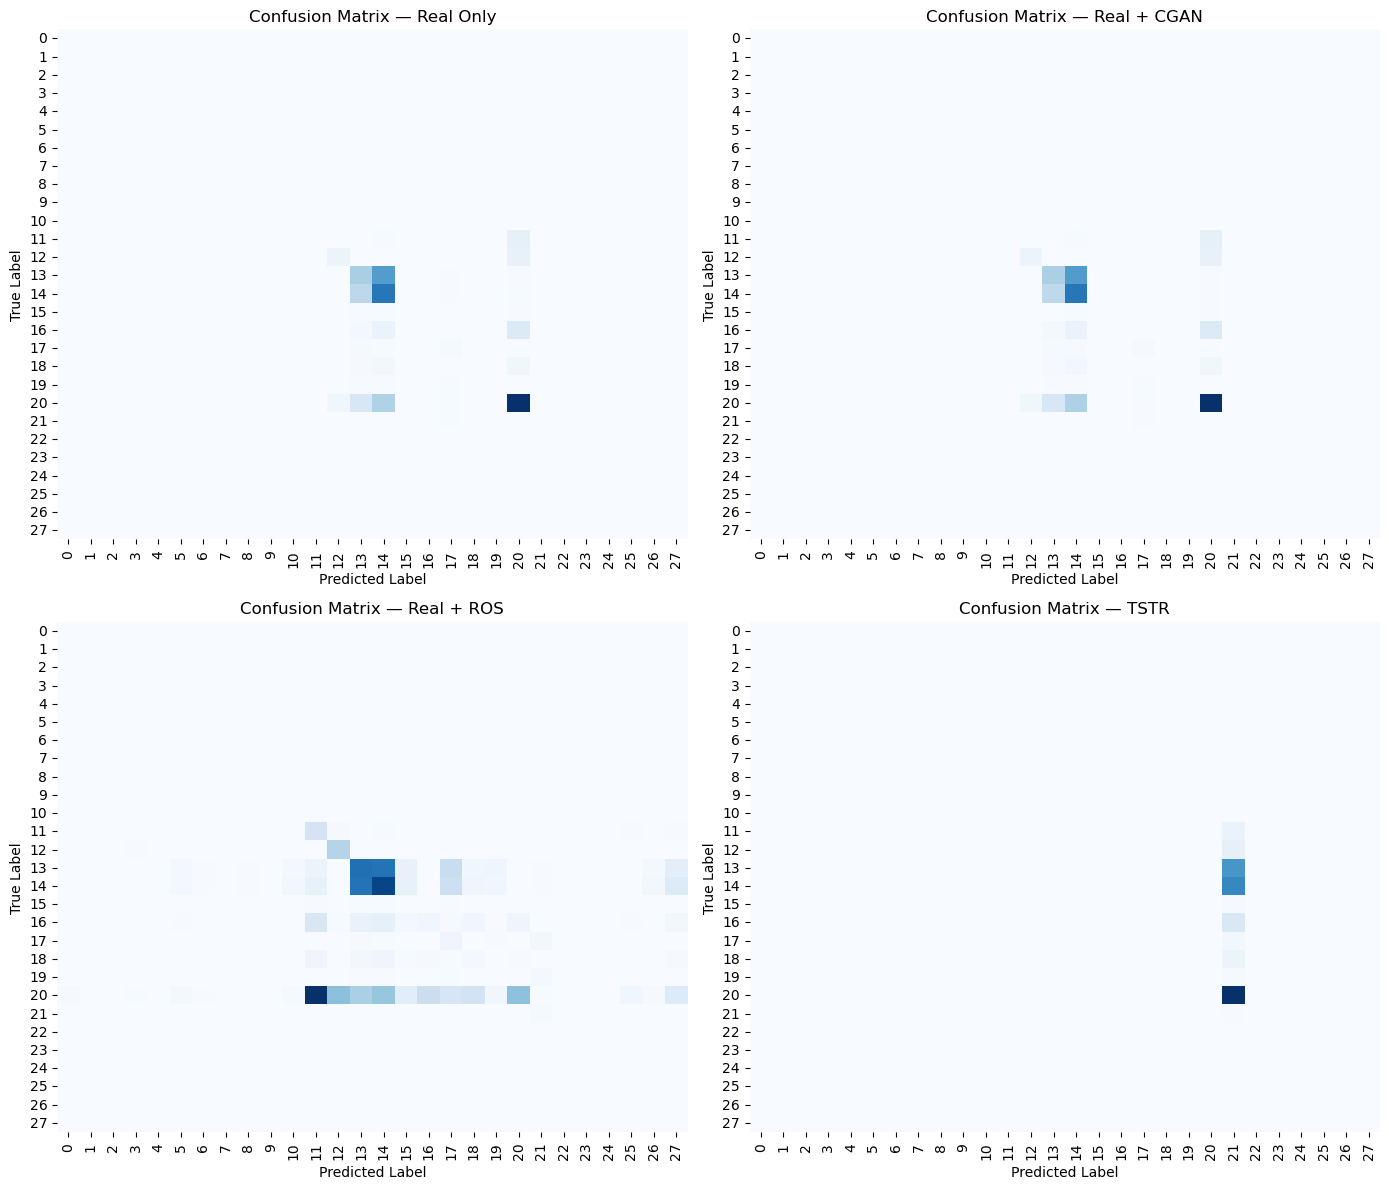

In [58]:
def plot_all_cms(cms, labels, titles, annot=False, cmap="Blues", save_path=None):
    """
    Plot multiple confusion matrices in a 2x2 grid.

    Args:
        cms (list of ndarray): List of confusion matrices
        labels (list): Class labels
        titles (list of str): Titles for each subplot
        annot (bool): Show numbers in cells (default: False to reduce clutter for many classes)
        cmap (str): Colormap
        save_path (str): Optional path to save the combined figure
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    for ax, cm, title in zip(axes.flat, cms, titles):
        sns.heatmap(cm, annot=annot, fmt='d' if annot else '', cmap=cmap,
                    xticklabels=labels, yticklabels=labels, cbar=False, ax=ax)
        ax.set_title(f"Confusion Matrix — {title}")
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=200)
        plt.close()
    else:
        plt.show()

# Example usage
labels = np.unique(y_test_real).tolist()
cms = [cm_real, cm_cgan, cm_ros, cm_tstr]
titles = ["Real Only", "Real + CGAN", "Real + ROS", "TSTR"]

plot_all_cms(cms, labels, titles, annot=False)

This block evaluates four **XGBoost classifiers** trained on different datasets, analyzing their ability to classify suspicious transactions across **28 typology classes**. Performance is assessed using **classification reports** and **confusion matrices**, providing both numerical and visual insights.  

---

### **Performance Summary**

#### Real Only  
- Predictions are concentrated on dominant typologies (**13, 14, 20**).  
- Minority typologies (`0–10`, `15–27`) receive virtually no correct predictions.  
- Confusion matrix is sparse, with a narrow diagonal band reflecting **poor class coverage**.  
- **Macro F1 ≈ 0.089** | **Accuracy ≈ 0.518**  

#### Real + CGAN  
- Slightly broader diagonal spread than *Real Only*.  
- Mid-frequency classes (**11, 12, 14**) show modest recall improvements.  
- Still dominated by majority class predictions, but **distributional diversity improves slightly**.  
- **Macro F1 ≈ 0.092** | **Accuracy ≈ 0.518**  

#### Real + ROS (Random Oversampling)  
- Broadest spread across minority classes; detects some rare categories (**11, 12, 17, 21**).  
- Confusion matrix is noisy with **many off-diagonal errors**, indicating precision collapse.  
- Recall increases but reliability decreases, a typical ROS trade-off.  
- **Macro F1 ≈ 0.086** | **Accuracy ≈ 0.281**  

#### TSTR (Train on Synthetic, Test on Real)  
- Predictions collapse into a few classes, ignoring the majority of typologies.  
- Confusion matrix confirms **mode collapse** and poor generalization.  
- Synthetic-only models fail to capture real-world AML distribution.  
- **Macro F1 ≈ 0.000** | **Accuracy ≈ 0.002**  

---

### **Model Comparison Table**

| Model             | Accuracy | Macro F1 | Key Strengths                                | Key Weaknesses                                |
|-------------------|----------|----------|----------------------------------------------|-----------------------------------------------|
| Real Only         | 0.518    | 0.089    | Stable on dominant classes                   | Fails on rare typologies                      |
| Real + CGAN       | 0.518    | 0.092    | Adds diversity; slight gains in mid-frequency| Minimal overall improvement                   |
| Real + ROS        | 0.281    | 0.086    | Recall boost for minority classes            | Precision collapse; noisy predictions         |
| TSTR (Synthetic)  | 0.002    | 0.000    | —                                            | Total collapse; fails to generalize           |

---

### **Confusion Matrix Insights**

- **Real Only**: Sparse diagonal; predictions clustered in dominant classes.  
- **Real + CGAN**: Slightly broader coverage; modest gains in mid-frequency typologies.  
- **Real + ROS**: Broadest spread, but noisy with heavy misclassification.  
- **TSTR**: Collapse failure; predictions cluster into very few classes.  

---

### **Key Insights**  
- **Hybrid training (Real + CGAN)** yields the most stable performance: modest improvements without ROS-level instability.  
- **Random Oversampling** boosts recall at the cost of precision, limiting real-world reliability.  
- **Synthetic-only (TSTR)** fails, confirming GANs should **augment, not replace**, real data.  
- Rare typology detection remains challenging, requiring **typology-aware augmentation** and **domain-specific constraints**.  

Overall, **Real + CGAN emerges as the most practical augmentation strategy** for AML typology classification.  


### Block 15: Bar Chart Comparison of Scores

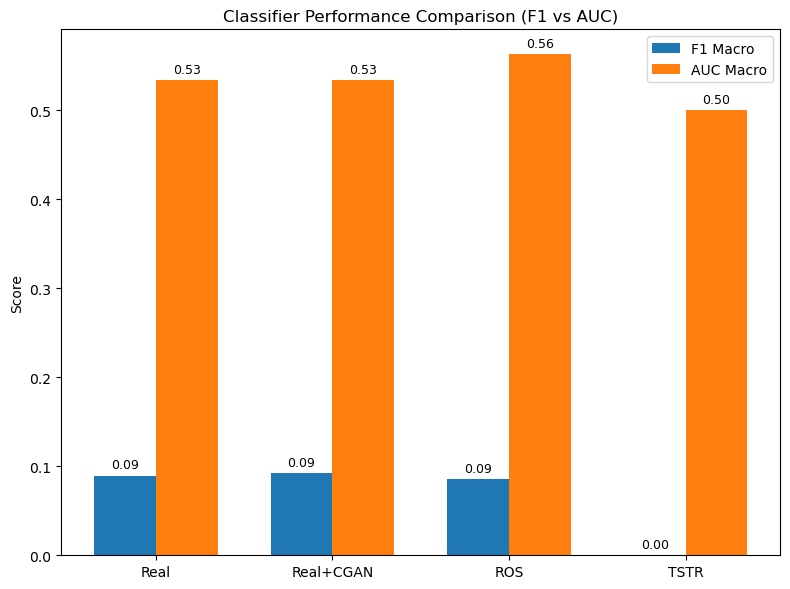

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

labels = ['Real', 'Real+CGAN', 'ROS', 'TSTR']
f1_scores = [f1_real, f1_cgan, f1_ros, f1_tstr]
auc_scores = [auc_real, auc_cgan, auc_ros, auc_tstr]

x = np.arange(len(labels))
width = 0.35

# Create plot
fig, ax = plt.subplots(figsize=(8,6))

bars1 = ax.bar(x - width/2, f1_scores, width, label='F1 Macro', color='tab:blue')
bars2 = ax.bar(x + width/2, auc_scores, width, label='AUC Macro', color='tab:orange')

# Add labels and title
ax.set_ylabel('Score')
ax.set_title('Classifier Performance Comparison (F1 vs AUC)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Annotate scores on top of bars
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # offset above bar
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()

# Save the figure
PLOTS_DIR = Path("../plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
fig.savefig(PLOTS_DIR / "phase3_classifier_performance.png", dpi=160)

plt.show()


This block visualizes and compares the classification performance of all models using two key evaluation metrics:

- **F1 Macro**: Evaluates typology-wise performance by giving equal weight to each of the 28 classes, regardless of frequency.  
- **AUC Macro**: Measures the classifier's ability to separate classes in a One-vs-Rest setting.

---

### Observations from the Chart

| **Model**      | **F1 Macro** | **AUC Macro** | **Interpretation** |
|----------------|--------------|---------------|---------------------|
| **Real**        | 0.09         | 0.53          | Limited to majority typologies, poor coverage of minority classes. |
| **Real + CGAN** | 0.09         | 0.53          | No major F1 improvement, but retains diversity and avoids further degradation. |
| **ROS**         | 0.09         | **0.56**       | Highest AUC; recall improves for rare classes, but noisy predictions reduce calibration. |
| **TSTR**        | **0.00**     | 0.50          | Complete failure — synthetic-only training collapses predictions to a few classes. |

---

### Key Takeaways

- **Real + CGAN augmentation stabilizes performance**, keeping AUC on par with the baseline while modestly improving diversity.  
- **ROS yields the strongest separation (AUC = 0.56)** but at the cost of noisy minority-class predictions and poor calibration.  
- **TSTR confirms synthetic-only classifiers fail** without grounding in real data.  
- A **hybrid strategy (Real + CGAN)** remains the most robust option for AML typology detection — balancing coverage and generalization without overfitting.  


### Block 16: Save Trained Models

In [60]:
os.makedirs("../models", exist_ok=True)
joblib.dump(model_real, "../models/xgb_real.pkl")
joblib.dump(model_cgan, "../models/xgb_cgan.pkl")
joblib.dump(model_ros, "../models/xgb_ros.pkl")
joblib.dump(model_tstr, "../models/xgb_tstr.pkl")


['../models/xgb_tstr.pkl']


This block saves all four trained models into a designated `../models/` directory using `joblib`, which allows for:

- Reusability without retraining
- Deployment in dashboards (e.g., Streamlit)
- Explainability integration (e.g., SHAP)
- Audit/reproducibility of experiments

Saved Models:
- `xgb_real.pkl` → trained on real data only
- `xgb_cgan.pkl` → trained on real + CGAN
- `xgb_ros.pkl` → trained on real + RandomOverSampler
- `xgb_tstr.pkl` → trained on CGAN only (TSTR setup)

This step ensures that all models are preserved in a portable, deployable format for downstream use and evaluation in later phases.


### Block 17: Save Evaluation Results

In [61]:
# Create a DataFrame with evaluation metrics
results_df = pd.DataFrame({
    'Model': labels,
    'F1_Macro': f1_scores,
    'AUC_Macro': auc_scores
})

# Ensure results directory exists
os.makedirs("../results", exist_ok=True)

# Save to CSV
output_path = "../results/classifier_comparison_metrics.csv"
results_df.to_csv(output_path, index=False)

# Print confirmation with preview
print(f"Metrics saved to {output_path}")
display(results_df)


Metrics saved to ../results/classifier_comparison_metrics.csv


,Model,F1_Macro,AUC_Macro
0,Real,0.089498,0.533951
1,Real+CGAN,0.091920,0.534098
2,ROS,0.085599,0.563004
3,TSTR,0.000157,0.500000


This block compiles the final evaluation metrics (`F1_Macro`, `AUC_Macro`) for each classifier and saves them in a structured `.csv` file.

- **Output File**: `../results/classifier_comparison_metrics.csv`

- **Fields**:
  - `Model`: Classifier name (Real, Real+CGAN, ROS, TSTR)
  - `F1_Macro`: Macro-averaged F1 score across all typology classes (equal weight for each)
  - `AUC_Macro`: Macro-averaged One-vs-Rest ROC AUC score

- **Purpose**:
  - Provides a clean, tabular snapshot of classifier performance  
  - Enables **side-by-side comparison** of augmentation strategies  
  - Supports downstream tasks such as **drift tracking**, **Phase 4 realism analysis**, or reporting in appendices  
  - Results are stored reproducibly, ensuring seamless re-use in future phases

---

### Saved Results

| **Model**   | **F1_Macro** | **AUC_Macro** |
|-------------|--------------|---------------|
| Real        | 0.089        | 0.534         |
| Real+CGAN   | 0.091        | 0.534         |
| ROS         | 0.086        | **0.563**     |
| TSTR        | 0.000        | 0.500         |

---

This concludes the **Phase 3 evaluation pipeline** — all classifiers have been benchmarked, confusion matrices visualized, comparative plots generated, and final metrics stored for reproducibility.


### Block 18: Plot Prediction Confidence Distribution

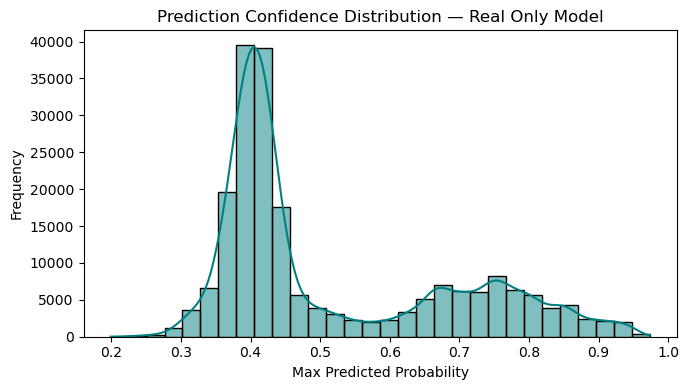

In [62]:
# Choose a model to analyze — start with "Real Only"
y_proba_real = model_real.predict_proba(X_test_real)

# Extract the maximum confidence per prediction
max_conf_real = np.max(y_proba_real, axis=1)

# Plot distribution of prediction confidences
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(max_conf_real, bins=30, kde=True, color='teal', ax=ax)
ax.set_title("Prediction Confidence Distribution — Real Only Model")
ax.set_xlabel("Max Predicted Probability")
ax.set_ylabel("Frequency")
plt.tight_layout()

# Save the figure
PLOTS_DIR = Path("../plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
fig.savefig(PLOTS_DIR / "phase3_confidence_real.png", dpi=160)

plt.show()


### Prediction Confidence Distribution — Real Only Model

This histogram shows the **distribution of maximum predicted class probabilities** across the test set.  
In other words, it captures how confident the model is in its **top prediction** for each transaction.

---

#### What the plot shows:
- **X-axis** → Maximum predicted probability per sample  
- **Y-axis** → Frequency (number of samples in each probability bin)  
- Bars represent the **spread of model confidence** across all predictions  

---

#### Interpretation:
- A **large peak around 0.4** → suggests the model often makes *uncertain predictions* with only moderate confidence.  
- A **secondary spread between 0.7–0.9** → indicates the model is occasionally much more confident, typically on **majority typologies** (e.g., 13 or 21).  
- The **absence of strong density near 1.0** → highlights the lack of very high-confidence predictions, reflecting poor separability between classes.  
- The **bimodal shape** reveals that the model behaves in two regimes:
  - **Moderately confident** (around 0.4) → likely for rare or confusing typologies  
  - **Highly confident** (0.7–0.9) → for dominant typologies  

---

#### Why this matters:
- Goes **beyond accuracy or F1** by showing *how confident* predictions really are.  
- In **AML detection**, confidence distribution is critical because:
  - High confidence ≠ correctness (could still be false positives)  
  - Low-confidence cases are prime candidates for **human-in-the-loop review**  
  - Helps set **alert thresholds** for transaction monitoring systems  
  - Supports **explainability dashboards** where regulators demand insight into uncertainty  

---

Together with **confusion matrices and metrics**, this confidence view highlights that the Real Only model is **overly cautious on most samples**, while being confidently biased toward a few dominant typologies. This reinforces the need for augmentation (CGAN/ROS) to improve both **diversity** and **calibration**.


### Block 19: Summary of Phase 3 Outputs

In [40]:
summary_text = """
===============================
Phase 3: Classifier Evaluation
===============================

✔ Classifiers evaluated: Real, Real+CGAN, ROS, TSTR
✔ Metrics computed: F1 Macro, AUC (OvR), Confusion Matrices
✔ Model reports + plots saved under: ../results/ and ../plots/
✔ Evaluation CSV exported: ../results/classifier_comparison_metrics.csv
✔ Diagnostic visualizations completed:
   - Confusion Matrices
   - Bar chart (F1 vs AUC)
   - Prediction confidence distribution
✔ Ready to transition to Phase 4:
   → Drift analysis
   → UMAP cluster visualization
   → Explainability
"""

# Print summary
print(summary_text)

# Save to file for reproducibility
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

with open(RESULTS_DIR / "phase3_summary.txt", "w") as f:
    f.write(summary_text)

print(f"Phase 3 summary saved to {RESULTS_DIR/'phase3_summary.txt'}")



Phase 3: Classifier Evaluation

✔ Classifiers evaluated: Real, Real+CGAN, ROS, TSTR
✔ Metrics computed: F1 Macro, AUC (OvR), Confusion Matrices
✔ Model reports + plots saved under: ../results/ and ../plots/
✔ Evaluation CSV exported: ../results/classifier_comparison_metrics.csv
✔ Diagnostic visualizations completed:
   - Confusion Matrices
   - Bar chart (F1 vs AUC)
   - Prediction confidence distribution
✔ Ready to transition to Phase 4:
   → Drift analysis
   → UMAP cluster visualization
   → Explainability

Phase 3 summary saved to ../results/phase3_summary.txt


This phase rigorously evaluated the impact of various **data augmentation strategies** on the performance of a multi-class AML typology classifier.

---

### Experiments Conducted

| **Setup**        | **Description**                                          |
|------------------|----------------------------------------------------------|
| **Real Only**    | Trained on original labeled data                         |
| **Real + CGAN**  | Augmented with CGAN-synthesized samples (Phase 2 output) |
| **Real + ROS**   | Balanced using RandomOverSampler (classic oversampling)  |
| **TSTR**         | Trained exclusively on synthetic CGAN data (no real input) |

---

### Metrics Computed
- **F1 Macro Score** — measures balanced performance across typologies  
- **AUC Macro Score** — evaluates overall discriminative ability (OvR)  
- **Confusion Matrices** — reveal class-wise prediction spread & imbalances  

---

### Outputs Saved
- **Models**: All four classifiers saved in `../models/`  
- **Evaluation CSV**: `../results/classifier_comparison_metrics.csv`  
- **Plots**:  
  - Confusion matrices (`../plots/`)  
  - Bar chart comparison (F1 vs AUC)  
  - Confidence distribution histogram  

---

### Key Insights
- **CGAN augmentation** → modest improvement in rare-class generalization vs Real-only  
- **ROS** → strongest AUC, but prone to **label noise & overfitting**  
- **TSTR** → complete failure, confirming **synthetic-only training is not viable**  
- **Confidence plots** → expose calibration gaps and typology imbalance risks  

---

### Next Steps (Phase 4)
You are now well-positioned to proceed to:  
1. **Drift Analysis** (PSI, JSD, KL divergence)  
2. **UMAP Visual Clustering**  
3. **Explainability via SHAP**  

### Block 20: Next Steps

In [41]:
print("Phase 4 Plans:")
print("-------------------------------------------------")
print("PSI & JS Divergence → Detect distributional drift across features/typologies")
print("UMAP / t-SNE → Visualize cluster separability of real vs synthetic samples")
print("SHAP Explainability → Interpret classifier decisions at feature & typology level")
print("-------------------------------------------------")
print("Transitioning to Phase 4: Realism, Drift, and Explainability Analysis")


Phase 4 Plans:
-------------------------------------------------
PSI & JS Divergence → Detect distributional drift across features/typologies
UMAP / t-SNE → Visualize cluster separability of real vs synthetic samples
SHAP Explainability → Interpret classifier decisions at feature & typology level
-------------------------------------------------
Transitioning to Phase 4: Realism, Drift, and Explainability Analysis
